# Credit Transaction Data Science Challenge

## Setup

In [1]:
#----------------------------------------------------------------------------------------------------
# imports for entire notebook
#----------------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # version 3.1.0
import pandas_profiling

from sklearn.model_selection import train_test_split # version 0.21.2
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# turning off warning
pd.options.mode.chained_assignment = None

In [2]:
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'pandas-profiling version: {pandas_profiling.__version__}')

numpy version: 1.16.4
pandas version: 0.24.2
pandas-profiling version: 2.3.0


## Question 1: Load

- Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found [here](https://github.com/CapitalOneRecruiting/DS)
- Please describe the structure of the data. Number of records and fields in each record?
- Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [3]:
#----------------------------------------------------------------------------------------------------
# read in line-delimited JSON file on transactional data from github
#----------------------------------------------------------------------------------------------------

url = 'https://raw.githubusercontent.com/CapitalOneRecruiting/DS/master/transactions.zip'

transactions_raw = pd.read_json(url, lines=True)

In [4]:
#----------------------------------------------------------------------------------------------------
# display sample, first 3 lines of dataframe
#----------------------------------------------------------------------------------------------------

transactions_raw.head(3)

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
0,733493772,2014-08-03,US,5000.00,492,9184,False,5000,0.00,04/2020,...,Lyft,,,01,05,,,111.33,2016-01-08T19:04:50,PURCHASE
1,733493772,2014-08-03,US,4888.67,492,9184,False,5000,111.33,06/2023,...,Uber,,,01,09,,,24.75,2016-01-09T22:32:39,PURCHASE
2,733493772,2014-08-03,US,4863.92,492,9184,False,5000,136.08,12/2027,...,Lyft,,,01,05,,,187.40,2016-01-11T13:36:55,PURCHASE


In [5]:
#----------------------------------------------------------------------------------------------------
# checking if datatypes seem appropriate
#----------------------------------------------------------------------------------------------------

transactions_raw.dtypes

accountNumber                 int64
accountOpenDate              object
acqCountry                   object
availableMoney              float64
cardCVV                       int64
cardLast4Digits               int64
cardPresent                    bool
creditLimit                   int64
currentBalance              float64
currentExpDate               object
customerId                    int64
dateOfLastAddressChange      object
echoBuffer                   object
enteredCVV                    int64
expirationDateKeyInMatch       bool
isFraud                        bool
merchantCategoryCode         object
merchantCity                 object
merchantCountryCode          object
merchantName                 object
merchantState                object
merchantZip                  object
posConditionCode             object
posEntryMode                 object
posOnPremises                object
recurringAuthInd             object
transactionAmount           float64
transactionDateTime         

In [6]:
#----------------------------------------------------------------------------------------------------
# correcting datatypes that appear to be incorrectly inferred
#----------------------------------------------------------------------------------------------------

transactions_raw['accountOpenDate'] = pd.to_datetime(transactions_raw['accountOpenDate'], format='%Y-%m-%d')
transactions_raw['currentExpDate'] = pd.to_datetime(transactions_raw['currentExpDate'], format='%m/%Y')
transactions_raw['dateOfLastAddressChange'] = pd.to_datetime(transactions_raw['dateOfLastAddressChange'], format='%Y-%m-%d')
transactions_raw['transactionDateTime'] = pd.to_datetime(transactions_raw['transactionDateTime'])

In [7]:
#----------------------------------------------------------------------------------------------------
# extract number of rows and columns in dataframe
#----------------------------------------------------------------------------------------------------

rows, cols = transactions_raw.shape

In [8]:
print(rows)
print(cols)

641914
29


**Please describe the structure of the data. Number of records and fields in each record.**
- Number of records: 641,914
- Number of fields: 29

**Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.**

- The code below uses pandas profiling to generate a univariate summary html report. The html file includes many statistics about each variables in the transactions dataset. Examples of metrics includes: # null, min, max, unique values for categorical varibles, etc.
- It appears as though a few of the variables in the dataset are not populated:
 - echoBuffer
 - merchantCity
 - merchantState
 - merchantZip
 - posOnPremises
 - recurringAuthInd
 
The requested values can all be found in the univariate_summary.html file

In [9]:
#----------------------------------------------------------------------------------------------------
# run pandas_profiling report (univariate summary) on the transaction dataframe & store html in current directory
# removed some functionality (ex. correlation checks) to improve performance
#----------------------------------------------------------------------------------------------------

profile = transactions_raw.profile_report(title='Transactions Univariate Summary'
                                          ,check_correlation_pearson=False
                                          ,correlations={'pearson': True, 'spearman': False, 'kendall': False
                                                         ,'phi_k': False, 'cramers': False, 'recoded':False}
                                          ,missing_diagrams={'bar': False, 'matrix': False
                                                             , 'heatmap': False, 'dendrogram': False}
                                          ,plot ={'histogram':{'bayesian_blocks_bins': False, 'bins': 20}}
                                         )
profile.to_file(output_file='univariate_summary.html')

## Question 2: Plot

**Plot a histogram of the processed amounts of each transaction, the 'transactionAmount' column.
Report any structure you find and any hypotheses you have about that structure.**

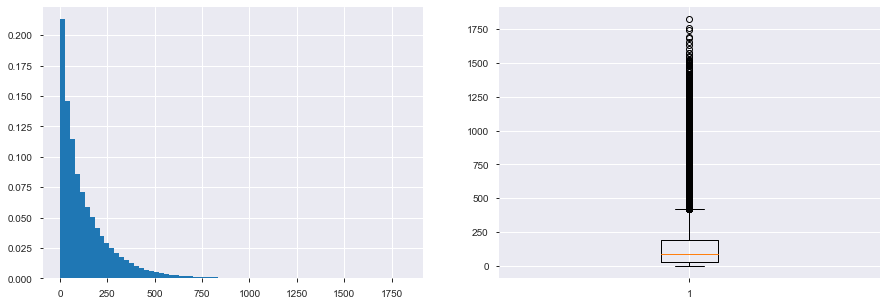

In [10]:
#----------------------------------------------------------------------------------------------------
# plot histogram & boxplot of 'transactionAmount' using matplotlib
#----------------------------------------------------------------------------------------------------

var = transactions_raw.transactionAmount

weights = np.ones(rows)/rows

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist(var, bins=70, weights=weights)

plt.subplot(122)
plt.boxplot(var)

plt.show()

The histogram for 'transactionAmount' is right skewed. As expected, purchases tend to be lower dollar amounts (< $250), but there is a long tail for less frequent, higher dollar amount purchases.

- As an example, consumers likely purchase groceries, gas, go out to eat, etc. on a weekly basis. All of which are generally below $150. However, consumers purchase higher dollar amount items such as  rent, purchase a new tv, etc., much less frequently.

- One other interesting observation is that ~3%  of observations have a $0 transaction amount. A large portion of which appear to be 'ADDRESS_VERIFICATION' transactions. 

In [11]:
transactions_raw[transactions_raw['transactionAmount']==0].groupby('transactionType',as_index=False).agg({'transactionAmount':'count'})

,transactionType,transactionAmount
0,ADDRESS_VERIFICATION,16478
1,PURCHASE,1500
2,REVERSAL,501


## Question 3: Data Wrangling - Duplicate Transactions

**You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span. Another example is a reversed transaction, where a purchase is followed by a reversal.**

- Can you programmatically identify duplicated and reversed transactions?
- Did you find anything interesting about either of these transaction types?
- What share of transactions (both number of transactions and the dollar amount) do you estimate for the duplicated and reversed transaction types that you identified? In a multi-swipe transaction, please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts.

### Multi-Swipe Transactions

In [12]:
#----------------------------------------------------------------------------------------------------
# create subset of data for analysis where the transactionAmount & vendor on a purchase transaction are the same for an account
#----------------------------------------------------------------------------------------------------

duplicate_cols = ['accountNumber','merchantName','transactionAmount']
keep_cols = duplicate_cols + ['transactionDateTime','transactionType']

purchase_fltr = transactions_raw['transactionType'] == 'PURCHASE'

duplicates = transactions_raw[purchase_fltr][duplicate_cols].duplicated(keep=False)

multi_swipe = transactions_raw[purchase_fltr][duplicates][keep_cols].sort_values(by=keep_cols)

In [13]:
#----------------------------------------------------------------------------------------------------
# create new variable which is the previous transactions timestamp to determine the time between transactions
# this will help define a cut-off point/duration for a 'multi-swipe' transaction vs. a subscription
#----------------------------------------------------------------------------------------------------

multi_swipe['transactionDateTime_lag'] = multi_swipe.groupby(duplicate_cols)['transactionDateTime'].shift(1)

multi_swipe['duration_s'] = (multi_swipe['transactionDateTime'] - multi_swipe['transactionDateTime_lag']).astype('timedelta64[s]')

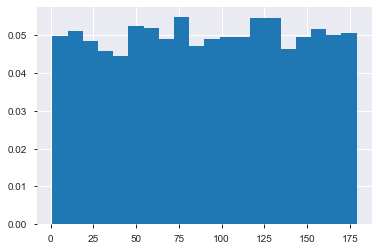

In [14]:
#----------------------------------------------------------------------------------------------------
# distribution of time (seconds) between potential duplicate transactions
#----------------------------------------------------------------------------------------------------

duration_window_s = 600

multi_swipe_obs = multi_swipe[multi_swipe['duration_s'] <= duration_window_s]

var = multi_swipe_obs['duration_s'].dropna()

weights = np.ones_like(var)/len(var)

plt.hist(var, bins=20, weights=weights)

plt.show()

Limited histogram window to within 10 min. period based on observation of results and intuition on how a mult-swipe transaction might occur. Based on the data, all duplicate transactions occur within 3 minutes or hours later (potentially subscription services). I've decided to define a multi-swipe transaction as a purchase transaction with the same vendor and amount within a 3 minute time period. This seems like a reasonable real-world scenario where the employee may ask to re-run your card during the transaction if it appears as though it didn't go through.

In [15]:
#----------------------------------------------------------------------------------------------------
# the following code (in combination with the two cells above the histogram) 
#   removes the multi-swipe transactions as defined above
#----------------------------------------------------------------------------------------------------

duration_window_s = 180

multi_swipe_obs = multi_swipe[multi_swipe['duration_s'] <= duration_window_s]

multi_swipe_obs.head()

,accountNumber,merchantName,transactionAmount,transactionDateTime,transactionType,transactionDateTime_lag,duration_s
21092,102307135,Universe Massage #777394,255.05,2016-05-24 22:54:22,PURCHASE,2016-05-24 22:52:55,87.0
478651,104678966,AMC #128743,635.18,2016-12-26 21:38:14,PURCHASE,2016-12-26 21:37:31,43.0
81298,104679201,1st Sandwitch Bar #801388,8.24,2016-08-17 12:09:11,PURCHASE,2016-08-17 12:07:06,125.0
81207,104679201,1st Sandwitch Bar #941288,18.90,2016-06-01 14:42:00,PURCHASE,2016-06-01 14:41:34,26.0
81436,104679201,Best Fries,65.55,2016-12-10 10:47:33,PURCHASE,2016-12-10 10:46:55,38.0


### Reversed Transactions

In [16]:
#----------------------------------------------------------------------------------------------------
# create subset of data for analysis where the transactionAmount & vendor on a transaction are the same for an account
#----------------------------------------------------------------------------------------------------

duplicate_cols = ['accountNumber','merchantName','transactionAmount']
keep_cols = duplicate_cols + ['transactionDateTime','transactionType']

duplicates = transactions_raw[duplicate_cols].duplicated(keep=False)

reverse_trans = transactions_raw[duplicates][keep_cols].sort_values(by=keep_cols)

In [17]:
#----------------------------------------------------------------------------------------------------
# create two new variables which are the previous transactions type & timestamp to help define a reverse transaction
#----------------------------------------------------------------------------------------------------

reverse_trans['transactionType_lag'] = reverse_trans.groupby(duplicate_cols)['transactionType'].shift(1)
reverse_trans['transactionType_lead'] = reverse_trans.groupby(duplicate_cols)['transactionType'].shift(-1)
reverse_trans['transactionDateTime_lag'] = reverse_trans.groupby(duplicate_cols)['transactionDateTime'].shift(1)

reverse_trans['duration_d'] = (reverse_trans['transactionDateTime'] - reverse_trans['transactionDateTime_lag']).astype('timedelta64[D]')

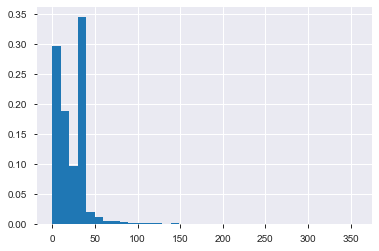

In [18]:
#----------------------------------------------------------------------------------------------------
# distribution of time (days) between reversal transactions
#----------------------------------------------------------------------------------------------------

duration_window_d = 360

reverse_trans_obs = reverse_trans[reverse_trans['duration_d'] <= duration_window_d]

var = reverse_trans_obs['duration_d'].dropna()

weights = np.ones_like(var)/len(var)

plt.hist(var, bins=36, weights=weights)

plt.show()

In [19]:
#----------------------------------------------------------------------------------------------------
# create two new variables which are the previous transactions type & timestamp to help define a reverse transaction
#----------------------------------------------------------------------------------------------------

purchases = (reverse_trans['transactionType']=='PURCHASE') & (reverse_trans['transactionType_lead']=='REVERSAL')
reversals = (reverse_trans['transactionType']=='REVERSAL') & (reverse_trans['transactionType_lag']=='PURCHASE')

reverse_trans_obs = reverse_trans[purchases | reversals]

reverse_trans_obs.head(6)

,accountNumber,merchantName,transactionAmount,transactionDateTime,transactionType,transactionType_lag,transactionType_lead,transactionDateTime_lag,duration_d
583531,100547107,Dunkin' Donuts #164240,223.42,2016-08-22 20:35:41,PURCHASE,NaN,REVERSAL,NaT,NaN
583532,100547107,Dunkin' Donuts #164240,223.42,2016-08-22 20:36:57,REVERSAL,PURCHASE,NaN,2016-08-22 20:35:41,0.0
583564,100547107,Subway #540372,316.52,2016-12-19 19:11:13,PURCHASE,NaN,REVERSAL,NaT,NaN
583565,100547107,Subway #540372,316.52,2016-12-19 19:11:57,REVERSAL,PURCHASE,NaN,2016-12-19 19:11:13,0.0
104583,100634414,Dunkin' Donuts #48174,85.51,2016-06-13 20:49:02,PURCHASE,NaN,REVERSAL,NaT,NaN
104585,100634414,Dunkin' Donuts #48174,85.51,2016-06-29 09:33:16,REVERSAL,PURCHASE,NaN,2016-06-13 20:49:02,15.0


### Results Summary

**Did you find anything interesting about either transaction?**

In [20]:
reversed_multi_swiped_trans = len(multi_swipe_obs.index & reverse_trans_obs.index)

print(reversed_multi_swiped_trans)

121


- Multi-swipe transactions seem to occur within 3 minutes or less.
- Reverse transactions occur within 365 days (assuming this is because of company return limits). There is a spike around 30 days, which I assume is also related to specific company return limits.
- There are a portion of transactions that appear to be multi-swipe transactions which are reversed later.
 - Estimated number of transactions (not including the reversal): 121

**What share of transactions (both number of transactions and the dollar amount) do you estimate for the duplicated and reversed transaction types that you identified? In a multi-swipe transaction, please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts.**

*for calculation purposes, all transaction amounts considered positive (ie reversal transactions values are not interpreted as negative amounts)

In [21]:
#----------------------------------------------------------------------------------------------------
# total (raw) transaction amount and counts
#----------------------------------------------------------------------------------------------------

total_transaction_count = rows
total_transaction_amount = np.sum(transactions_raw['transactionAmount'])

print(total_transaction_count)
print(total_transaction_amount)

641914
86762699.08999997


In [22]:
#----------------------------------------------------------------------------------------------------
# mult-swipe transaction amount and counts
#----------------------------------------------------------------------------------------------------

multi_swipe_count = len(multi_swipe_obs)
multi_swipe_amount = np.sum(multi_swipe_obs['transactionAmount'])

print(multi_swipe_count)
print(multi_swipe_amount)

print(multi_swipe_count/total_transaction_count)
print(multi_swipe_amount/total_transaction_amount)

5989
886953.5800000001
0.009329910237196882
0.010222752280677122


In [23]:
#----------------------------------------------------------------------------------------------------
# reverse transactions transaction amount and counts
#----------------------------------------------------------------------------------------------------

reverse_trans_count = len(reverse_trans_obs)
reverse_trans_amount = np.sum(reverse_trans_obs['transactionAmount'])

print(reverse_trans_count)
print(reverse_trans_amount)

print(reverse_trans_count/total_transaction_count)
print(reverse_trans_amount/total_transaction_amount)

28178
4239436.62
0.043896845994946365
0.04886243356263482


**Total Transactions**
- Number of transactions: 641,914
- Amount of transactions: $86,762,699

**Multi-swipe Transactions**
- Number (%) of transactions: 5,989 (0.93%)
- Amount (%) of transactions: $886,953 (1.02%)

**Reverse Transactions**
- Number (%) of transactions: 28,178 (4.39%)
- Amount (%) of transactions: $4,239,436 (4.89%)

## Question 4: Model

**Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.**

- Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
- Provide an estimate of performance using an appropriate sample, and show your work.
- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

### Data Exploration

In [24]:
#------------------------------------------------------------------------------------------
# variable transformations
#------------------------------------------------------------------------------------------

transactions_raw['months_account_open'] = (transactions_raw['transactionDateTime'] - transactions_raw['accountOpenDate']).astype('timedelta64[M]')
transactions_raw['months_address_change'] = (transactions_raw['transactionDateTime'] - transactions_raw['dateOfLastAddressChange']).astype('timedelta64[M]')
transactions_raw['transaction_month'] = pd.DatetimeIndex(transactions_raw['transactionDateTime']).month
transactions_raw['transaction_hour'] = pd.DatetimeIndex(transactions_raw['transactionDateTime']).hour
transactions_raw['valid_CVV'] = (transactions_raw['cardCVV'] == transactions_raw['enteredCVV']) * 1
transactions_raw['expirationDateKeyInMatch'] = transactions_raw['expirationDateKeyInMatch'] * 1
transactions_raw['cardPresent'] = transactions_raw['cardPresent'] * 1
transactions_raw['merchant_name_condensed'] = transactions_raw['merchantName'].apply(lambda x: x.split('#')[0].strip())

#### Categorical Features

In [25]:
var = 'merchantName'

temp_df = transactions_raw.groupby(var, as_index=False).agg({'isFraud':'mean','accountNumber':'count'}).sort_values('isFraud')

print(temp_df.iloc[:10])
print(temp_df.iloc[-10:])

               merchantName  isFraud  accountNumber
782   Hilton Hotels #151328      0.0             96
912        In-N-Out #711158      0.0             89
1994     Sunoco Gas #387323      0.0            184
1995     Sunoco Gas #398682      0.0            119
1996     Sunoco Gas #403204      0.0            244
1997     Sunoco Gas #413153      0.0            183
1998     Sunoco Gas #418291      0.0            177
1993     Sunoco Gas #380975      0.0             84
1999     Sunoco Gas #425592      0.0            271
2001     Sunoco Gas #482324      0.0            265
             merchantName   isFraud  accountNumber
849   Hyatt House #461673  0.125000            104
859   Hyatt House #687337  0.125000            112
852   Hyatt House #524654  0.125000            120
1445  Powerlifting #95081  0.129032             31
1181         NYSC #746171  0.130435             23
858   Hyatt House #686333  0.134146             82
2328    Walgreens #856780  0.157895             19
575           Fast R

In [26]:
var = 'merchant_name_condensed'

temp_df = transactions_raw.groupby(var, as_index=False).agg({'isFraud':'mean','accountNumber':'count'}).sort_values('isFraud')

print(temp_df.iloc[:10])
print(temp_df.iloc[-10:])

    merchant_name_condensed  isFraud  accountNumber
155               Texas Gas      0.0           4163
149              Sprint PCS      0.0            307
184                 abc.com      0.0           2894
22                 Barbells      0.0            214
138               Shell Gas      0.0           6350
112       Northtown Massage      0.0            237
30             Boost Mobile      0.0            213
148   Sprint Communications      0.0            136
59               Duane Reed      0.0             28
104                 MyApron      0.0           1102
     merchant_name_condensed   isFraud  accountNumber
16         American Airlines  0.036254           1986
95           Marriott Hotels  0.036697            109
23               Best Bistro  0.037868           1426
40  Convenient Auto Services  0.038241            523
88             John's Bistro  0.038411            755
33              Boston Diner  0.038674            724
5                   34th BBQ  0.040661           5

In [27]:
#----------------------------------------------------------------------------------------------------
# function to create a bar chart displaying fraud rate by value for an input variable
#----------------------------------------------------------------------------------------------------

def categoricalBivariatePlot(var):
    tmp_df = (transactions_raw
              .groupby(var, as_index=False)
              .agg({'isFraud':'mean'})
              .sort_values('isFraud')
             )
    
    plt.bar(tmp_df[var], tmp_df.isFraud)
    plt.xticks(rotation=90)    
    plt.title(var)
    plt.show()    

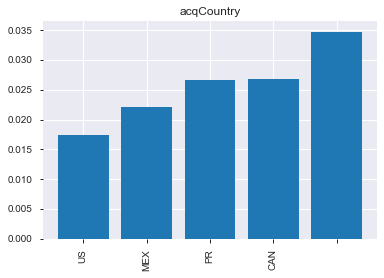

In [28]:
var = 'acqCountry'

categoricalBivariatePlot(var)

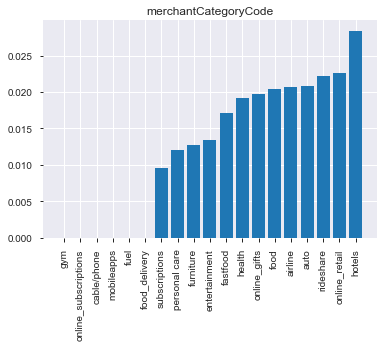

In [29]:
var = 'merchantCategoryCode'

categoricalBivariatePlot(var)

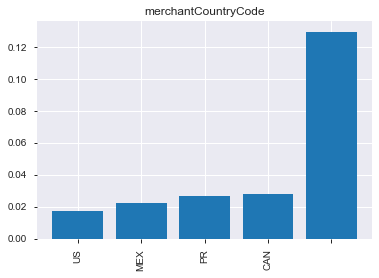

In [30]:
var = 'merchantCountryCode'


categoricalBivariatePlot(var)

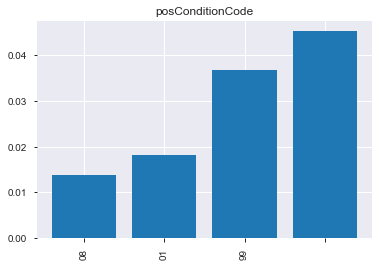

In [31]:
var = 'posConditionCode'

categoricalBivariatePlot(var)

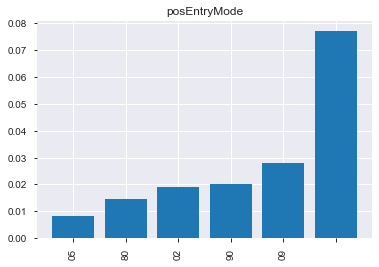

In [32]:
var = 'posEntryMode'

categoricalBivariatePlot(var)

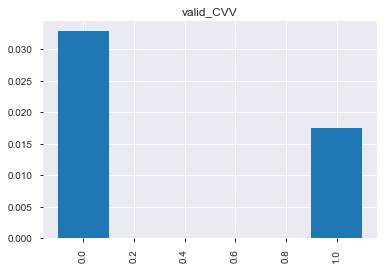

In [33]:
var = 'valid_CVV'

categoricalBivariatePlot(var)

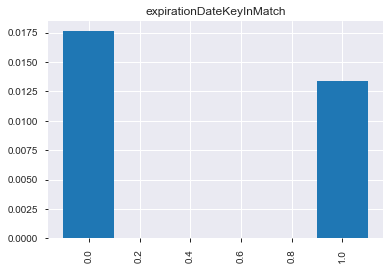

In [34]:
var = 'expirationDateKeyInMatch'

categoricalBivariatePlot(var)

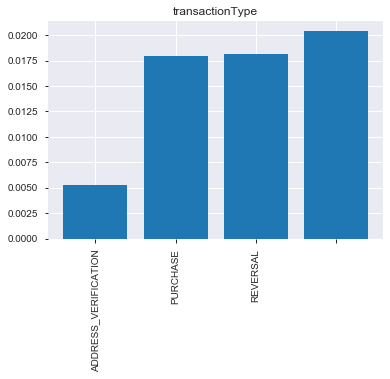

In [35]:
var = 'transactionType'

categoricalBivariatePlot(var)

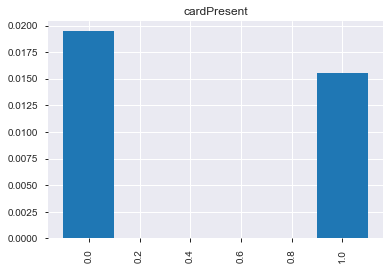

In [36]:
var = 'cardPresent'

categoricalBivariatePlot(var)

#### Continuous Features

In [37]:
#----------------------------------------------------------------------------------------------------
# function to create a bar chart displaying fraud rate by value for an input variable
#  optional parameter for n quantiles
#----------------------------------------------------------------------------------------------------

def continuousBivariatePlot(var, n_bins = None):
    tmp_df = transactions_raw[[var,'isFraud']]
    
    if n_bins:
        tmp_df[var + '_bin'] = pd.qcut(tmp_df[var], n_bins)
        plot_var = var + '_bin'
    else:
        plot_var = var

    plot_df = (tmp_df
               .groupby(plot_var, as_index=False)
               .agg({'isFraud':'mean'})
               .sort_values(plot_var)
              )
    plt.bar(plot_df.index, plot_df.isFraud)
    plt.xticks(range(len(plot_df[plot_var])),plot_df[plot_var], rotation=90)
    plt.title(var)
    plt.show()

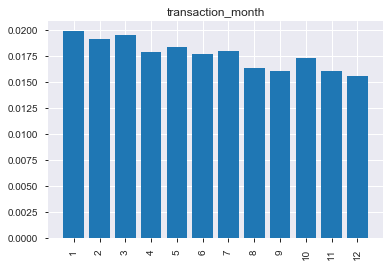

In [38]:
var = 'transaction_month'

continuousBivariatePlot(var)

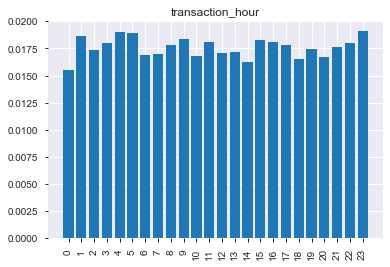

In [39]:
var = 'transaction_hour'

continuousBivariatePlot(var)

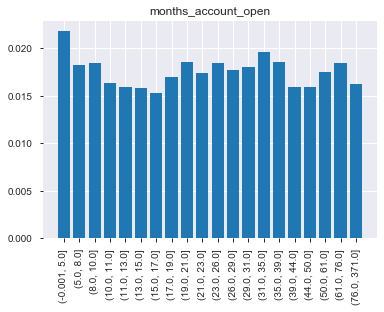

In [40]:
var = 'months_account_open'

continuousBivariatePlot(var, 20)

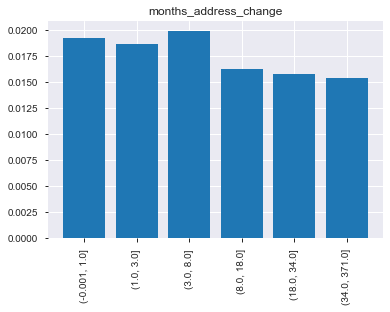

In [41]:
var = 'months_address_change'

continuousBivariatePlot(var, 6)

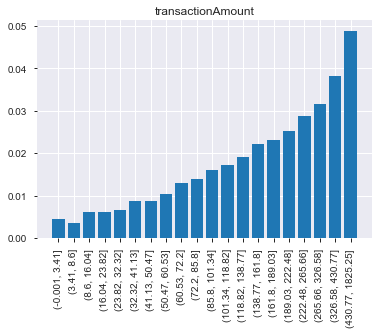

In [42]:
var = 'transactionAmount'

continuousBivariatePlot(var, 20)

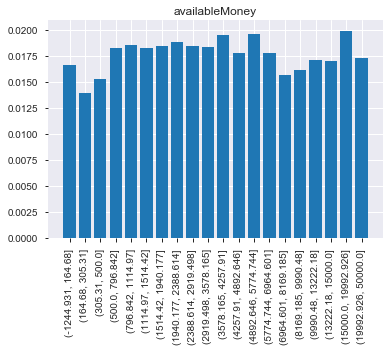

In [43]:
var = 'availableMoney'

continuousBivariatePlot(var, 20)

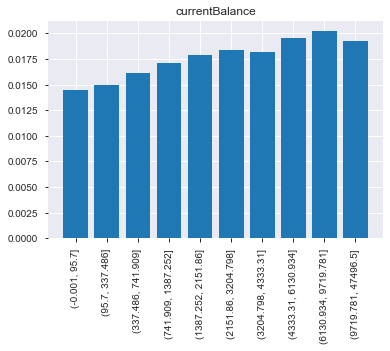

In [44]:
var = 'currentBalance'

continuousBivariatePlot(var, 10)

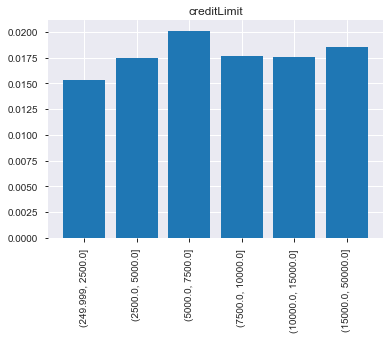

In [45]:
var = 'creditLimit'

continuousBivariatePlot(var, 6)

### Data Preparation

In [46]:
#------------------------------------------------------------------------------------------
# constants
#------------------------------------------------------------------------------------------

random_seed = 14

In [47]:
#------------------------------------------------------------------------------------------
# creating starting point for independent and dependent varaible dataframes
#------------------------------------------------------------------------------------------

initial_features = ['valid_CVV'
                    ,'months_account_open'
                    ,'expirationDateKeyInMatch'
                    ,'transactionAmount'
                    ,'currentBalance'
                    ,'creditLimit'
                    ,'months_address_change'
                    ,'cardPresent'
                    ,'transactionType' # one hot encode
                    ,'transaction_month' # one hot encode
                    ,'transaction_hour' # one hot encode
                    ,'acqCountry' # one hot encode
                    ,'merchantCategoryCode' # one hot encode
                    ,'merchantCountryCode' # one hot encode
                    ,'merchant_name_condensed' # one hot encode
                    ,'posConditionCode' # one hot encode
                    ,'posEntryMode' # one hot encode
                   ]

target = 'isFraud'

x = transactions_raw[initial_features]
y = transactions_raw[target] * 1

In [48]:
#------------------------------------------------------------------------------------------
# one hot encoding categorical variables (including variables which are integer codes)
#------------------------------------------------------------------------------------------

one_hot_encode_dict = {'acqCountry':'acqCountry','merchantCategoryCode':'merchCat'
                       ,'merchantCountryCode':'merchCountry','merchant_name_condensed':'merchName'
                       ,'posConditionCode':'posCondition','posEntryMode':'posEntry'
                       ,'transactionType':'type'
                       ,'transaction_month':'trans_month','transaction_hour':'trans_hour'
                      }

x_transformed = pd.get_dummies(x, prefix=one_hot_encode_dict, columns=list(one_hot_encode_dict.keys()))

features = x_transformed.columns

In [49]:
#------------------------------------------------------------------------------------------
# train_test split of data
#------------------------------------------------------------------------------------------

test_proportion = 0.2

x_train, x_test, y_train, y_test = train_test_split(x_transformed, y, test_size=test_proportion, random_state=random_seed)

In [50]:
#------------------------------------------------------------------------------------------
# fraud has a low rate of occurrence (<2%) based on the profiling report
# oversample (with replacement) minority class to produce a 50% event rate for modeling
#------------------------------------------------------------------------------------------

x_train[target] = y_train

desired_event_rate = 0.5

train_events = x_train[x_train[target] == 1]
train_non_events = x_train[x_train[target] == 0]

num_train_events = int(len(train_non_events)/((1-desired_event_rate)/desired_event_rate))

train_events_upsampled = resample(train_events, replace = True, n_samples = num_train_events, random_state = random_seed)

train_upsampled = train_events_upsampled.append(train_non_events, ignore_index = True)

x_train_upsampled = train_upsampled[features]

y_train_upsampled = train_upsampled[target]

### Model Build

In [51]:
#------------------------------------------------------------------------------------------
# grid search on random forest
#------------------------------------------------------------------------------------------

rf = RandomForestClassifier(min_samples_split = 10, min_samples_leaf = 5)

param_grid = {'n_estimators': [10,20,40]}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(x_train_upsampled, y_train_upsampled)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [52]:
#------------------------------------------------------------------------------------------
# grid search results
#------------------------------------------------------------------------------------------

grid_search.cv_results_

{'mean_fit_time': array([ 65.80084117, 125.53330278, 248.36854188]),
 'std_fit_time': array([1.60938879, 1.92058429, 3.07842867]),
 'mean_score_time': array([ 4.01096567,  6.52853751, 11.4204541 ]),
 'std_score_time': array([0.07272829, 0.02099702, 0.04230467]),
 'param_n_estimators': masked_array(data=[10, 20, 40],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10}, {'n_estimators': 20}, {'n_estimators': 40}],
 'split0_test_score': array([0.96044299, 0.96880928, 0.9719667 ]),
 'split1_test_score': array([0.96198603, 0.96814033, 0.97379218]),
 'split2_test_score': array([0.96137631, 0.96714712, 0.97178815]),
 'mean_test_score': array([0.96126844, 0.96803224, 0.97251568]),
 'std_test_score': array([0.00063454, 0.00068286, 0.00090556]),
 'rank_test_score': array([3, 2, 1])}

In [53]:
#------------------------------------------------------------------------------------------
# parameters for best performing model
#------------------------------------------------------------------------------------------

grid_search.best_params_

{'n_estimators': 40}

In [54]:
#------------------------------------------------------------------------------------------
# accuracy score for best performing model
#------------------------------------------------------------------------------------------

grid_search.best_score_

0.9725156781441517

In [55]:
#------------------------------------------------------------------------------------------
# assigning best performing model to selected_rf variable
#------------------------------------------------------------------------------------------

selected_rf = grid_search.best_estimator_

In [56]:
#------------------------------------------------------------------------------------------
# dataframe containing feature importances
#------------------------------------------------------------------------------------------

feature_importances = (pd.DataFrame(selected_rf.feature_importances_
                                   , index = features
                                   , columns = ['importance']
                                  )
                       .sort_values('importance', ascending=False)
                      )

feature_importances

,importance
transactionAmount,1.716823e-01
currentBalance,7.016282e-02
months_account_open,6.842555e-02
posEntry_05,5.999536e-02
months_address_change,5.713245e-02
creditLimit,4.524432e-02
posEntry_09,2.289916e-02
merchCat_fuel,1.244141e-02
merchName_Hyatt House,1.100190e-02
posEntry_02,9.169097e-03


In [57]:
#------------------------------------------------------------------------------------------
# predicted probabilites on the test set (not upsampled)
#------------------------------------------------------------------------------------------

pred_prob = [i[1] for i in selected_rf.predict_proba(x_test)]

In [58]:
#------------------------------------------------------------------------------------------
# confusion matrix of results
# defaulted threshold to 0.5; with more time I would explore the threshold value with an
#  emphasis on the cost of each decision about a transaction
#------------------------------------------------------------------------------------------

threshold = 0.5

pd.crosstab(y_test
            ,np.where(np.array(pred_prob) > threshold, 1, 0)
            ,rownames=['actual']
            ,colnames=['predicted']
            ,margins=True
           ) / len(y_test)

predicted,0,1,All
actual,,,
0,0.947703,0.034420,0.982124
1,0.013522,0.004354,0.017876
All,0.961225,0.038775,1.000000


The model correctly classified about 25% of the fraudulent transactions on the validation dataset. A 75% false negative rate seems very high, which leaves room for improvement through data preparation, sampling, tuning, and the probability threshold for classifying a transaction. More details can be found in the summary section.

### Summary

**Modeling algorithm/method used and why:**

- I chose a random forest because it is generally capable of building a decently predictive model without investing a lot of time to identify non-linear relationships, interaction terms, etc. It is also robust to overfitting by randomly selecting features for each tree.
- Random forest is an algorithm I am very familiar with and, therefore, is an algorithm I'll often use as a first pass to build a benchmark for performance. From that initial pass, I'll work on developing a better understanding of the relationships modeled via partial dependendence plots, tune parameters, assess other algorithms where necessary, etc.

**What features/data you found useful:**
- The following are the top 10 variables based on the feature importances:
 1. transactionAmount
 2. currentBalance
 3. months_account_open
 4. posEntry_05
 5. months_address_change
 6. creditLimit
 7. posEntry_09
 8. merchCat_fuel
 9. merchName_Hyatt House
 10. posEntry_02 

There are a variety of features that appear to have predictive power.

- Transaction amount: based on bivariate plot & feature importance list, there is a clear trend with the likelihood of fraud. Higher transaction amount = higher likelihood of fraud. It is intuitive that fraud attempts would occur on bigger ticket items. It could also make sense that fraud is less likely to be identified or could be overlooked if it's on a lower priced item.
- A few of the transformations led to some value: months_account_open and months_address_change. The newer an account is, the higher the likelihood of fraud. Potential hypothesis is that new accounts/cards could be more easily stolen while in the mail.
- posEntry appears to be a very important variable. Based on some quick research it appears as though it's related to how the card is used (swiped, inserted with a chip, etc.). I couldn't find precise definitions for the codes, but it is intuitive that less secure methods could lead to more fraud.
- Hyatt House had a significant amount of fraud. It would be interesting to dig deeper into the specific store #'s and identify the root cause of this.

**What questions you have:**
- What process would occur after a charge is predicted to be fraudulent?
- I hypothesize that the cost of a false negative is higher than the cost of a false positive. From a business perspective, what extent is this the case? What are the implications of not automatically identifying fraudulent charges? What are the costs associated with processing a fraudulent charge?
- What do values in 'posConditionCode' stand for?
- What do values in 'posEntryMode' stand for? Based on quick research it seems like it's related to how the card was used (swipe, insert, etc.). But it'd be useful to have a mapping of code to the precise definition.
- For the variables that were completely null/blank, why were they blank? Is there potential predictive power in these variables?
- What other variables are available to model fraud? (1st or 3rd party)
- How would the model be implemented? ie would all of the variables be available for scoring at the instance the transaction needs to be classified? Additional decisions made during model development could be impacted by implementation constraints.
- It seems like there are a few businesses where fraud is more prevalent. What steps could be taken to proactively reduce fraud?

**What you would do next with more time:**

Data Preparation
- Additional variable transformations:
 - Transaction amount relative to the average per account/customer, relative to the average per category per account/customer
 - Likelihood of customer making a purchase at that time of day
 - Potentially create indicator variables to isolate predictive power of variables (ex. first month of account_months_open)
 - Further refinement of transformations made (ex. days since account open)
 - MerchantName: revisit transaction code or store id to identify if there are certain stores where fraud is more likely to occur than just companies. There appeared to be companies with high fraud rates, so for speed and to reduce dimensionality I removed the # <id>
- Revisit variables that I may have prematurely threw out just based on bivariate plots (ex. availableMoney); there may be value once controlling for other factors
- Assess strategy for handling of nulls; they appear to all be empty strings and are currently treated as a separate category for categorical variables. This may unnecessarily increase dimensionality. 

Model Performance:
- Assess sampling strategy; for oversampling positive events, I would explore leveraging synthetic generation instead of sampling with replacement
- With additional domain knowledge, I would like to evaluate the threshold for declaration of a positive/negative event; cost of false negative vs. false positive. This could also impact how to approach modeling and the penalization of false negatives
- Create partial dependence plots for understanding relationships random forest identified
- More thorough parameter tuning
- Assess additional modeling strategies

Other considerations:
- Gain a better grasp on domain knowledge, including understanding the cost of a false positive vs false negative
- Acquisition of additional observations/data (3rd party data sources?)
- Build out a pipeline for easy scoring of new datasets in the future
- Conduct additional research on best practices for modeling rare events